# Table of Contents

In [1]:
from PIL import Image
import scipy.misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

In [2]:
from matplotlib.font_manager import FontProperties
def display_image_samples(data, labels=None): # labels are used for plot titles and are optional
    
    font = FontProperties()
    font.set_family('monospace')
    
    plt.figure(figsize=(8,4))
    rows, cols = 2, 4 # these are arbitrary
    random_ids = random.sample(range(len(data)), rows*cols) # randomly select the images
    
    for i in range(rows*cols):

        curr_index = random_ids[i]
        image = data[curr_index]
        title_str = ('shape: ' + str(image.shape))
        
        if labels:
            title_str += ('\nclass ' + str(labels[i]))
        
        plt.subplot(rows, cols, i+1)
        plt.title(title_str, fontproperties=font)
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Fetch Data

In [3]:
def clean_data(data):
    
    # cropped_data = []
    
    # apply greyscale
    data = data.mean(3) # dimension 3 of image shape corresponds to color channels
    # data = data[:, :, :, 0] # same as above
    
    # center-crop images
    # data = data[:, :, 7:data.shape[2]-1]
    
    print(data.shape)
    
    return data

In [4]:
from sklearn.model_selection import train_test_split
def load_data(data_path, k, test_size=0.3):

    x = []
    y = []

    for i in range(k):
        curr_dir_path = data_path + 'c' + str(i) + '/'

        for file in os.listdir(curr_dir_path):
            file_name = os.fsdecode(file)

            if file_name.endswith(".jpg"):
                file_path = (os.path.join(curr_dir_path, file_name))
                img = np.asarray(Image.open(file_path))#.flatten()
                x.append(img)
                y.append(i)
                
    
    # apply greyscale and cropping
    x = clean_data(np.asarray(x))
    
    # np.asarray(x_train), np.asarray(labels)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

    return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test)

# Convolutional Neural Network

In [5]:
# taken from: https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    
    # Print New Line on Complete
    if iteration == total: 
        print()

In [6]:
def conv_net(names, data, labels, x_test, y_test, num_epochs):  
    
    def conv_layer(x, W, b):
        conv = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")
        conv_with_b = tf.nn.bias_add(conv,b)
        conv_out = tf.nn.relu(conv_with_b)
        
        return conv_out
    
    def maxpool_layer(conv, k=2):
        return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    
    def model(x):
        # define all needed variables
        W1 = tf.Variable(tf.random_normal([5,5,1,64]))
        b1 = tf.Variable(tf.random_normal([64]))

        W2 = tf.Variable(tf.random_normal([5,5,64,64]))
        b2 = tf.Variable(tf.random_normal([64]))

        W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
        b3 = tf.Variable(tf.random_normal([1024]))

        W_out = tf.Variable(tf.random_normal([1024, len(names)]))
        b_out = tf.Variable(tf.random_normal([len(names)]))
    
        # define the actual model
        x_reshaped = tf.reshape(x, shape=[-1,24,24,1])
        
        # 1: conv + pool layer 
        conv_out1 = conv_layer(x_reshaped, W1, b1)
        maxpool_out1 = maxpool_layer(conv_out1)
        norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
        
        # 2: conv + pool layer
        conv_out2 = conv_layer(norm1, W2, b2)
        norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
        maxpool_out2 = maxpool_layer(norm2)
        
        # 3: fully connected layer 
        maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
        local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
        local_out = tf.nn.relu(local)
        
        # obtain the final predition
        out = tf.add(tf.matmul(local_out, W_out), b_out)
                
        return out
    
    def run_model():
        
        num_batches = 5
        
        # define the x and y placeholders
        x = tf.placeholder(tf.float32, [None, 24*24])
        y = tf.placeholder(tf.float32, [None, len(names)])
        
        # run the model
        y_predicted = model(x)
        
        # define the cost
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predicted, labels=y))
        
        # get the optimizer
        train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)
        
        # train the Model
        with tf.Session() as s:
            s.run(tf.global_variables_initializer())
            onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
            onehot_vals = s.run(onehot_labels)
            batch_size = len(data) // num_batches
            print("batch size: ", batch_size, '\n')
            
            for j in range(0, num_epochs):
                
                printProgressBar(0, 1, prefix='EPOCH ' + str(j) + ': ', length=50)

                # if j % 10 == 0: print("\nEPOCH ", j+1)
                total_cost = 0
                for i in range(0, len(data), batch_size):
                    batch_data = data[i:i+batch_size, :]
                    batch_onehot_vals = onehot_vals[i:i+batch_size, :]
                    _, c = s.run([train_op, cost], feed_dict={x: batch_data, y: batch_onehot_vals})
                    total_cost += c
                    # if (j % 10 == 0) and (i % batch_size == 0): print("batch", i + 1, ", cost =", total_cost)
                    printProgressBar(i, len(data), prefix='EPOCH ' + str(j) + ': ', suffix='Cost = ' + str(total_cost), length=50)
                print()    
                # if j % 10 == 0: print("> Total Cost =", total_cost)
                
        # obtain the accuracy on the trained model
        correct_pred = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        with tf.Session() as s:
            
            onehot_ytest_tf = tf.one_hot(y_test, len(names), on_value=1., off_value=0., axis=-1)
            onehot_ytest = s.run(onehot_ytest_tf)
            
            s.run(tf.global_variables_initializer())
            accuracy_val = s.run(accuracy,feed_dict={x: x_test, y:onehot_ytest})
            print("\nACCURACY = ", accuracy_val*100, "%")

    run_model()

# Implementation

In [7]:
csv_path = '../dataset/driver_imgs_list.csv'
# train_data_path = '../dataset/original/train/'
train_data_path = '../dataset/resized/'
# train_data_path = '../dataset/samples/'

drivers_csv = pd.read_csv(csv_path)
classes = (np.unique(np.asarray(drivers_csv)[:,1]))
NUM_CLASSES = len(classes) # 10

# fetch images from stored dataset in path
x_train, y_train, x_test, y_test = load_data(train_data_path, NUM_CLASSES) # test perc = 0.3 (default)

(22424, 24, 24)


(15024, 24, 24)


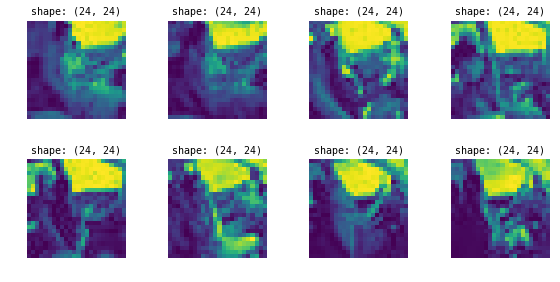

In [ ]:
print(x_train.shape)

# print a sample of images
display_image_samples(x_train)

In [ ]:
names = classes

print('\n------------------------------------ CONFIGURATION ------------------------------------\n')
print('data shape (original):', x_train.shape) # (13, 24, 24)

# want to flatten it, like: (13, 576)
data = x_train.reshape(x_train.shape[0], -1) # the -1 would be automatically calculated as 24*24 (=576)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)
labels = y_train

print('data shape (flattened):' , data.shape)
print('\nnames:', names, '\nnames shape:', names.shape)
print('\nlabels shape:', labels.shape)
print('\n-----------------------------------------------------------------------------------------\n')

# SIZES: names: [] x 10 , data:(50000, 576), labels:(50000,)
num_epochs = 2
conv_net(names, data, labels, x_test_flattened, y_test, num_epochs)


------------------------------------ CONFIGURATION ------------------------------------

data shape (original): (15024, 24, 24)
data shape (flattened): (15024, 576)

names: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9'] 
names shape: (10,)

labels shape: (15024,)

-----------------------------------------------------------------------------------------

batch size:  3004 

